# Imports

In [160]:
import os
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt
import kagglehub
import keras
import h5py
import PIL
import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass

In [82]:
RANDOM_SEED = 42
BATCH_SIZE = 32
IMAGE_SHAPE = (150, 150, 3)
CLASS_COUNT = 6
EPOCH = 10

In [152]:
df_check = pd.read_csv('train.csv')

# Data

Load and prepare your dataset. Dataset should have at least 10k samples in it. Each dataset cannot be used by more than two students.

In [4]:
PATH_TO_DATA_SET = '/home/timohavdk/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2'

In [8]:
path = kagglehub.dataset_download('puneet6060/intel-image-classification')

print('Path to dataset files:', path)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 346M/346M [00:42<00:00, 8.45MB/s]

Extracting files...


Path to dataset files: /home/timohavdk/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [93]:
def make_csv_map(path_to_folder, split_name):
    d = {'image_path': [], 'label': []}
    df = pd.DataFrame(data=d)

    lables = os.listdir(path_to_folder)

    for i in range(0, len(lables)):
        sub_dir = f'{path_to_folder}/{lables[i]}'
        
        files = os.listdir(sub_dir)

        for file in files:
            file_path = f'{sub_dir}/{file}'
            label = i

            new_d = {'image_path': [file_path], 'label': [int(label)]}
            new_df = pd.DataFrame(data=new_d)

            df = pd.concat([df, new_df])

    df['label'] = df['label'].astype('int32')
    
    df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    
    df.to_csv(f'{split_name}.csv', index=False)
            
    return lables

In [94]:
paths = [
    (f'{PATH_TO_DATA_SET}/seg_train/seg_train', 'train'),
    (f'{PATH_TO_DATA_SET}/seg_test/seg_test', 'test'),
]

In [95]:
for path, split_name in paths:
    labels = make_csv_map(path, split_name)

    print(labels)

['glacier', 'mountain', 'street', 'sea', 'forest', 'buildings']
['glacier', 'mountain', 'street', 'sea', 'forest', 'buildings']


# Backbone

Load pretrained model from Hugging Face (or some other model repository if it's more convenient). Model should be trained on Feature Extraction task.

In [38]:
RES_NET_SRC = 'microsoft/resnet-50'

In [39]:
processor = transformers.AutoImageProcessor.from_pretrained(RES_NET_SRC)

Load tokenizer to be used with the model

In [40]:
backbone = transformers.TFResNetModel.from_pretrained(RES_NET_SRC)

I0000 00:00:1733654805.336045    7241 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1414 MB memory:  -> device: 0, name: NVIDIA GeForce GT 1030, pci bus id: 0000:09:00.0, compute capability: 6.1
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFResNetModel: ['resnet.encoder.stages.2.layers.1.layer.0.normalization.num_batches_tracked', 'resnet.encoder.stages.3.layers.2.layer.1.normalization.num_batches_tracked', 'resnet.encoder.stages.3.layers.0.layer.2.normalization.num_batches_tracked', 'resnet.encoder.stages.2.layers.0.layer.2.normalization.num_batches_tracked', 'resnet.encoder.stages.1.layers.0.layer.1.normalization.num_batches_tracked', 'resnet.encoder.stages.2.layers.2.layer.1.normalization.num_batches_tracked', 'resnet.encoder.stages.2.layers.2.layer.0.normalization.num_batches_tracked', 'resnet.encoder.stages.2.layers.4.layer.0.normalization.num_batches_tracked', 'resnet.encoder.stages.1.layers.2.layer.1.n

# Feature extraction

Since we will not be training the backbone, extract features from your dataset.

Run the backbone on the images and save the extracted features. Don't forget to process the images. Images don't have to be of the same size, though it would be faster if they were. If the images don't fit in memory, lazily load them from disk

In [96]:
files_name = ['train.h5', 'test.h5']
csv_files = ['train.csv', 'test.csv']

In [123]:
def preprocess_and_save_to_hdf5(file_name, csv_file, processor):
    df_dataset = pd.read_csv(csv_file)

    # images_count = len(df_dataset)
    
    with h5py.File(file_name, "w") as h5file:
        images_dset = h5file.create_dataset('images', shape=(0, 2048, 7, 7), maxshape=(None, 2048, 7, 7))
        labels_dset = h5file.create_dataset('labels', shape=(0,), maxshape=(None,))
    
        for i in tqdm.tqdm(range(0, 1000)):
            image = PIL.Image.open(df_dataset['image_path'][i])
            image = np.asarray(image)
            
            processed = processor(image, return_tensors="tf")["pixel_values"]
            features = backbone(processed).last_hidden_state.numpy()
            
            images_dset.resize((images_dset.shape[0] + features.shape[0]), axis=0)
            images_dset[-features.shape[0]:] = features

            labels_dset.resize((labels_dset.shape[0] + features.shape[0]), axis=0)
            labels_dset[-features.shape[0]:] = df_dataset['label'][i]
        
        print(f"Данные сохранены в {file_name}")

In [124]:
for file_name, csv_file in zip(files_name, csv_files):
    preprocess_and_save_to_hdf5(file_name, csv_file, processor)

  0%|          | 0/1000 [00:00<?, ?it/s]

Данные сохранены в train.h5


  0%|          | 0/1000 [00:00<?, ?it/s]

Данные сохранены в test.h5


# Prepare train/test data

Split your data (extracted features and labels) into train and test subsets.

In [125]:
def check_hdf5_dataset(filepath):
    dataset = None
    with h5py.File(filepath, "r") as h5file:
        images = h5file["images"][:]
        labels = h5file["labels"][:]

        print(images.shape, labels.shape)

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [128]:
def create_hdf5_dataset(h5_file_path):
    def load_data_from_h5(index):
        with h5py.File(h5_file_path, "r") as h5file:
            features = h5file["images"][index]
            labels = h5file["labels"][index]
        return features, labels
    
    def get_item(index):
        features, labels = tf.py_function(
            func=load_data_from_h5,
            inp=[index],
            Tout=[tf.float32, tf.int32]
        )
        
        features.set_shape((2048, 7, 7))
        labels.set_shape(())
        return features, labels
    
    with h5py.File(h5_file_path, "r") as h5file:
        dataset_size = len(h5file["labels"])

        print(dataset_size)

        indices = tf.data.Dataset.range(dataset_size)
        dataset = indices.map(get_item, num_parallel_calls=tf.data.AUTOTUNE)
        return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [129]:
train_ds = create_hdf5_dataset("train.h5")
validation_ds = train_ds.take(4)
train_ds = train_ds.skip(4)
test_ds = create_hdf5_dataset("test.h5")

1000
1000


# Build the model

Build a simple model. The model should accept an extracted feature vector and return a vector of class logits (or probabilities). Model should only have a couple (or even 1) layers with weights.

In [155]:
def get_model():
    inputs = keras.layers.Input(shape=(2048, 7, 7))
    x = keras.layers.GlobalAveragePooling2D()(inputs) 
    x = keras.layers.Dense(256, activation="relu")(x) 
    x = keras.layers.Dropout(0.25)(x)
    outputs = keras.layers.Dense(CLASS_COUNT, activation="softmax")(x)

    model = keras.models.Model(inputs, outputs)

In [144]:
model = get_model()

Compile the model. Choose loss and metrics.

In [145]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model

In [161]:
HISTORY_DIR = './history'
os.makedirs(HISTORY_DIR, exist_ok=True)

In [162]:
logdir = os.path.join(HISTORY_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [163]:
def get_callbacks(model_name: str):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        os.path.join(logdir, f'model-{model_name}.keras'),
        save_best_only=True
    )

    return model_checkpoint_callback

In [164]:
checkpoint_callback = get_callbacks('res-net-image-classification')

In [146]:
model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCH,
    callbacks=[checkpoint_callback]
)

Epoch 1/3
28/28 ━━━━━━━━━━━━━━━━━━━━ 211s 7s/step - accuracy: 0.1638 - loss: 1.7910 - val_accuracy: 0.1797 - val_loss: 1.7899
Epoch 2/3
28/28 ━━━━━━━━━━━━━━━━━━━━ 211s 7s/step - accuracy: 0.1813 - loss: 1.7876 - val_accuracy: 0.1797 - val_loss: 1.7868
Epoch 3/3
28/28 ━━━━━━━━━━━━━━━━━━━━ 212s 7s/step - accuracy: 0.1813 - loss: 1.7868 - val_accuracy: 0.1797 - val_loss: 1.7843


# Evaluation

Evalute the model on test data.

In [147]:
model.evaluate(test_ds)

32/32 ━━━━━━━━━━━━━━━━━━━━ 182s 6s/step - accuracy: 0.1615 - loss: 1.7899


[1.7914137840270996, 0.1509999930858612]

Plot confusion matrix.

In [148]:
images_test = None
labels_test = None

with h5py.File('test.h5', "r") as h5file:
    images_test = h5file["images"][:]
    labels_test = h5file["labels"][:]

In [149]:
images_test.shape

(1000, 2048, 7, 7)

In [150]:
predictions = model.predict(images_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


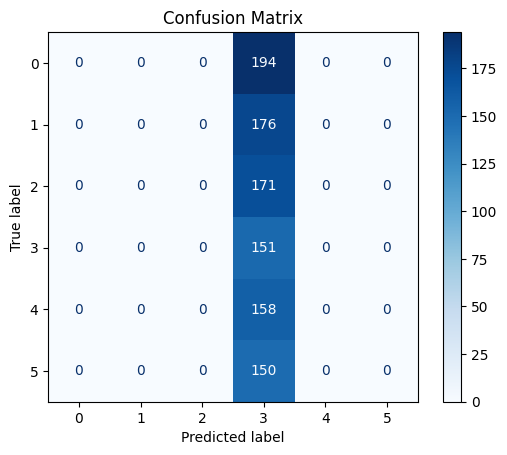

In [151]:
predicted_labels = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(labels_test, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1, 2, 3, 4, 5])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

Perform dimensiality reduction and plot the extracted features. Do classes form clusters?

# Bonus

Check if the feature extractor model can be used without a classifier layer (how large is the average feature vector similarity inbetween the same and different classes)